# Step by Step OCR
This notebook contains all steps of OCR

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

sys.path.append('../src')
from ocr.normalization import word_normalization, letter_normalization
from ocr import page, words, characters
from ocr.helpers import implt, resize
from ocr.tfhelpers import Model
from ocr.datahelpers import idx2char

Loading segmentation models...
INFO:tensorflow:Restoring parameters from c:\Users\johan\Documents\7. Semester\Datenwissenschaft\handwriting-ocr\src\ocr\../../models/gap-clas/CNN-CG
INFO:tensorflow:Restoring parameters from c:\Users\johan\Documents\7. Semester\Datenwissenschaft\handwriting-ocr\src\ocr\../../models/gap-clas/RNN/Bi-RNN-new


In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 10.0)

### Global Variables

In [3]:
IMG = '../data/pages/test4.jpg'    # 1, 2, 3
LANG = 'en'
# You can use only one of these two
# You HABE TO train the CTC model by yourself using word_classifier_CTC.ipynb
MODEL_LOC_CHARS = '../models/char-clas/' + LANG + '/CharClassifier'
MODEL_LOC_CTC = '../models/word-clas/CTC/Classifier1'

## Load Trained Model

In [4]:
CHARACTER_MODEL = Model(MODEL_LOC_CHARS)
CTC_MODEL = Model(MODEL_LOC_CTC, 'word_prediction')

INFO:tensorflow:Restoring parameters from ../models/char-clas/en/CharClassifier
INFO:tensorflow:Restoring parameters from ../models/word-clas/CTC/Classifier1


## Load image

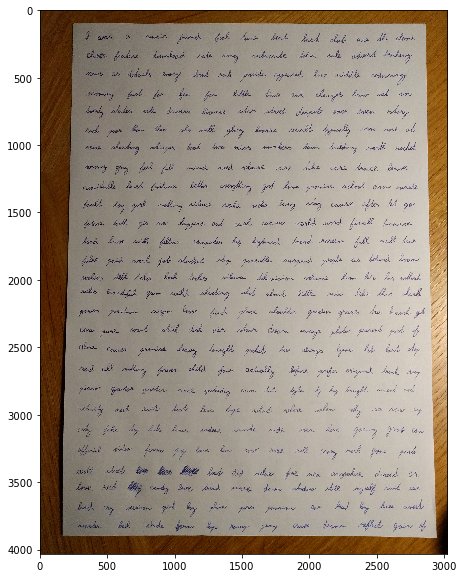

In [5]:
image = cv2.cvtColor(cv2.imread(IMG), cv2.COLOR_BGR2RGB)
implt(image)

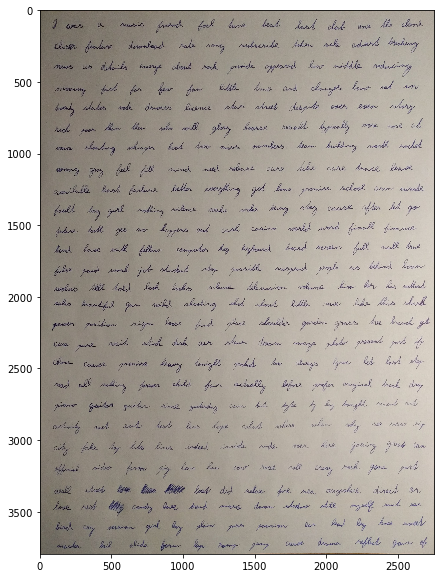

ValueError: too many values to unpack (expected 2)

In [6]:
# Crop image and get bounding boxes
crop = page.detection(image)
implt(crop)
boxes = words.detection(crop)
lines = words.sort_words(boxes)

# Recognition Using Character + Separator Model

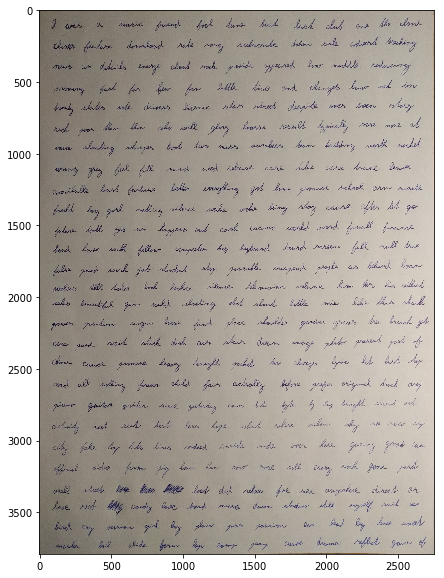

I upas a music friend fool tune beat last club one the clone
closer feature downloact rale song subscriebe token sale advert breakeng
news as details emerp about rock provide apYeared low middle reducing
pnoving fast far few fgn little time and changes lanp net in
toenty states oote drivers liance stm street despite over wen story
rich than then who will glory hoarse result typically sore nose at
poor
voice skouting rohisper boot two miss numbers team building north rochet
vvrong gray fed fill mincl need release ciare take care trace leave
amilable least failure better everything got home pmm school arm minute
fault bog girl nothing silence wake woke beinvg stay cause after let v
future tooth yes no kappens out cash asino world npord finall finance
bond have with fellonr computer key keyboard board screen frll null true
fwlee pw work job strdont stop possible suspenct people us bekind loan
wolees tell tald look looks silence televesion volermee him ber his wdeout
rules beautiful gun wi

In [ ]:
def recognise(img):
    """Recognition using character model"""
    # Pre-processing the word
    img = word_normalization(
        img,
        60,
        border=False,
        tilt=True,
        hyst_norm=True)

    # Separate letters
    img = cv2.copyMakeBorder(
        img,
        0, 0, 30, 30,
        cv2.BORDER_CONSTANT,
        value=[0, 0, 0])
    gaps = characters.segment(img, RNN=True)

    chars = []
    for i in range(len(gaps)-1):
        char = img[:, gaps[i]:gaps[i+1]]
        char, dim = letter_normalization(char, is_thresh=True, dim=True)
        # TODO Test different values
        if dim[0] > 4 and dim[1] > 4:
            chars.append(char.flatten())

    chars = np.array(chars)
    word = ''        
    if len(chars) != 0:
        pred = CHARACTER_MODEL.run(chars)                
        for c in pred:
            word += idx2char(c)

    return word

implt(crop)
for line in lines:
    print(" ".join([recognise(crop[y1:y2, x1:x2]) for (x1, y1, x2, y2) in line]))

# Recognition Using CTC Model

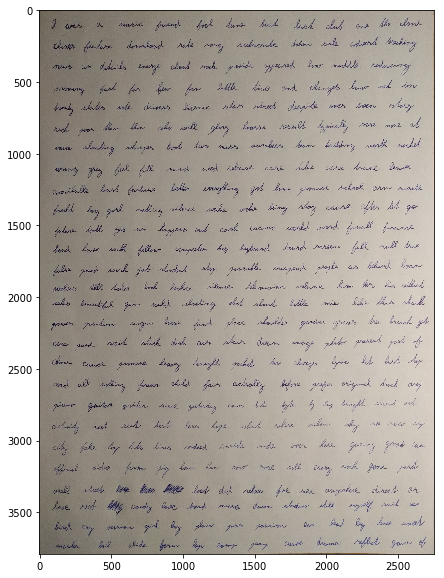

I was a music friend bool tune beat last club one the clone
closer feature downlaad rate song subscribe tohen sale advert broking
news as details energe about rock prvide appeared low middler reducing
moving fast far few far little tin and changes lan net in
tventy states vote drivers licence star street despite over even story
rich Sthai then who will gloy hoarse result Apically sore mose at
poor
voice shanting whisper boot two miss numbers team building morth rocket
wrong gray beel fill mind need rebase care the cure trace lave
available bast farlune better everghing got home promise schooh arm minute
foult boy girl natking silance wake woke bing stay cause after let go
future tooth yes no happens out cash casino world word fimall firance
bond have with bellow computer key kegboard baard screen full wull true
false paid work job stednt stop possible suspend people us behind loan
walves sell told look looks silence delevision valume him her his without
rules beantiful gur wild shactin

In [ ]:
def recognise(img):
    """Recognising words using CTC Model."""
    img = word_normalization(
        img,
        64,
        border=False,
        tilt=False,
        hyst_norm=False)
    length = img.shape[1]
    # Input has shape [batch_size, height, width, 1]
    input_imgs = np.zeros(
            (1, 64, length, 1), dtype=np.uint8)
    input_imgs[0][:, :length, 0] = img

    pred = CTC_MODEL.eval_feed({
        'inputs:0': input_imgs,
        'inputs_length:0': [length],
        'keep_prob:0': 1})[0]

    word = ''
    for i in pred:
        word += idx2char(i)
    return word

implt(crop)
for line in lines:
    print(" ".join([recognise(crop[y1:y2, x1:x2]) for (x1, y1, x2, y2) in line]))